# Bag of Words Sentiment Analyse von McDonalds Reviews und IMBD Daten

## Zielsetzung 
In diesem Notebook erweitern wir die McDonald's-Daten mit IMDB-Daten, um die Auswirkungen auf die Genauigkeit zu erforschen. Dafür teilen wir die Daten in positive und negative Reviews auf, was zu nur zwei Labels führt. Die Baseline basierend auf dem gesunden Menschenverstand liegt daher bei einer Genauigkeit von 50%.
 Unser Ziel ist es herauszufinden, ob wir durch Hinzufügen immer mehr Daten eine allgemeine Semantikanalyse erreichen können, die auf jede beliebige Review angewendet werden kann.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers


2023-07-03 16:50:00.801576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Datenvorbereitung inkl. Behandlung bekannter Probleme

### Laden der Daten

In [ ]:
%pip install kaggle

In [ ]:
!kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
!unzip mcdonalds-store-reviews.zip

In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

 97%|████████████████████████████████████▉ | 25.0M/25.7M [00:13<00:00, 5.82MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:13<00:00, 2.05MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [40]:
df_mc = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df_imdb = pd.read_csv('IMDB Dataset.csv')


### Löschen der 3 Sterne Bewertungen beim McDonalds Dataset

In [41]:
df_mc = df_mc[df_mc['rating'] != '3 stars']


In [83]:
print(df_mc.columns)
print(df_imdb.columns)

Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')
Index(['review', 'sentiment'], dtype='object')


### Konvertierung der train data zu numpy arrays

In [42]:
data_mc = df_mc['review'].to_numpy()
data_imdb = df_imdb['review'].to_numpy()


### Konvertierung der Datasets von string labels zu Nummern

In [43]:
rating_mapping_imdb = {
    'positive': 1,
    'negative': 0,
}

label_imdb = df_imdb['sentiment'].map(rating_mapping_imdb).to_numpy()


In [44]:
rating_mapping_mc = {
    '1 star': 0,
    '2 stars': 0,
    '4 stars': 1,
    '5 stars': 1
}

label_mc = df_mc['rating'].map(rating_mapping_mc).to_numpy()

### Daten zusammenführen

In [45]:
data = np.append(data_imdb, data_mc)
label = np.append(label_imdb,label_mc)
print(data.shape)
print(label.shape)

(78578,)
(78578,)


### Aufteilung in Trainings, Validierungs und Testdaten

In [46]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(62862,)
(15716,)
(62862,)
(15716,)


#### McDonalds Train/Test split

Um die Veränderung des Ergbnisses, durch das Einführen von Testsdaten vergleichen zu können, werden wir später auch noch ein Model nur mit den McD Daten trainieren

In [47]:
train_data_mc, test_data_mc, train_label_mc, test_label_mc = train_test_split(data_mc, label_mc, test_size=0.2, random_state=42)

print(train_data_mc.shape)
print(test_data_mc.shape)
print(train_label_mc.shape)
print(test_label_mc.shape)

(22862,)
(5716,)
(22862,)
(5716,)


#### IMDB Train/Test split

Um die Veränderung des Ergbnisses, durch das Einführen von Testsdaten vergleichen zu können, werden wir später auch noch ein Model nur mit den McD Daten trainieren

In [48]:
train_data_imdb, test_data_imdb, train_label_imdb, test_label_imdb = train_test_split(data_imdb, label_imdb, test_size=0.2, random_state=42)

print(train_data_imdb.shape)
print(test_data_imdb.shape)
print(train_label_imdb.shape)
print(test_label_imdb.shape)

(40000,)
(10000,)
(40000,)
(10000,)


### Text zu Dictonary Repräsentationen umbauen
Erklärung Menge an Tokens
Erklärung ngrams 
Erklärung multi_hot und warum

In [80]:
text_vectorization = TextVectorization(
 max_tokens=30000,
ngrams=3,
 output_mode="multi_hot",
)

In [81]:
text_vectorization.adapt(train_data) 
text_vectorization.adapt(test_data) 

multi_hot_train_data = text_vectorization(train_data)
multi_hot_test_data = text_vectorization(test_data)

#### Text Vectorization für McD

In [82]:
text_vectorization_mc = TextVectorization(
 max_tokens=30000,
ngrams=3,
 output_mode="multi_hot",
)

text_vectorization_mc.adapt(train_data_mc) 
text_vectorization_mc.adapt(test_data_mc) 

multi_hot_train_data_mc = text_vectorization_mc(train_data_mc)
multi_hot_test_data_mc = text_vectorization_mc(test_data_mc)

#### Text Vectorization für IMDB

In [84]:
text_vectorization_imdb = TextVectorization(
 max_tokens=30000,
ngrams=3,
 output_mode="multi_hot",
)

text_vectorization_imdb.adapt(train_data_imdb) 
text_vectorization_imdb.adapt(test_data_imdb) 

multi_hot_train_data_imdb = text_vectorization_imdb(train_data_imdb)
multi_hot_test_data_imdb = text_vectorization_imdb(test_data_imdb)

## Erstellung eines entsprechenden künstlichen neuronalen Models sowie geeigente Benchmarks

In [86]:
def get_model(max_tokens=30000, hidden_dim=64):
 inputs = keras.Input(shape=(max_tokens,))
 x = layers.Dense(hidden_dim, activation="relu")(inputs)
 x = layers.Dense(32, activation="relu")(x)
 x = layers.Dropout(0.5)(x)
 x = layers.Dense(16, activation="relu")(x)
 outputs = layers.Dense(1, activation="sigmoid")(x)
 model = keras.Model(inputs, outputs)
 model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"], 
 )
 return model

model = get_model()
model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_28 (Dense)            (None, 64)                1920064   
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,922,689
Trainable params: 1,922,689
Non-tra

In [87]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]

In [88]:
history = model.fit(multi_hot_train_data,train_label,
validation_split=0.4,
 epochs=10, 
 callbacks= callbacks
 )

Epoch 1/10


1179/1179 [==============================] - 28s 23ms/step - loss: 0.3322 - accuracy: 0.8684 - val_loss: 0.2705 - val_accuracy: 0.8961
Epoch 2/10
1179/1179 [==============================] - 28s 24ms/step - loss: 0.1921 - accuracy: 0.9322 - val_loss: 0.2868 - val_accuracy: 0.9001
Epoch 3/10
1179/1179 [==============================] - 27s 23ms/step - loss: 0.1341 - accuracy: 0.9557 - val_loss: 0.3847 - val_accuracy: 0.8985
Epoch 4/10
1179/1179 [==============================] - 26s 22ms/step - loss: 0.0939 - accuracy: 0.9700 - val_loss: 0.5719 - val_accuracy: 0.8979


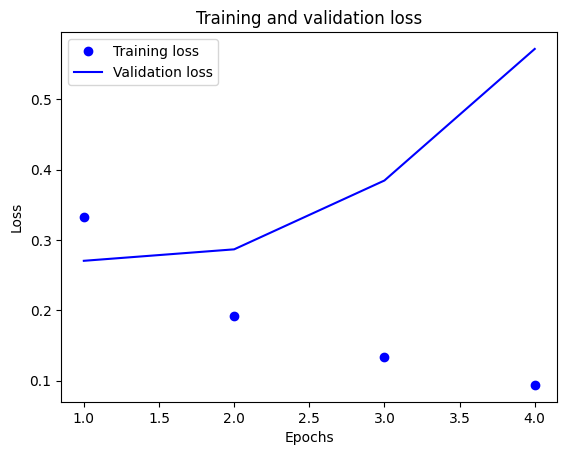

In [89]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluierung auf alle Daten


In [90]:
model.evaluate(multi_hot_test_data, test_label)

  1/492 [..............................] - ETA: 17s - loss: 0.2710 - accuracy: 0.8750

492/492 [==============================] - 2s 5ms/step - loss: 0.2562 - accuracy: 0.9017


[0.2561749219894409, 0.9016925692558289]

### Evalurierung nur auf die McDonalds Daten

In [91]:
model.evaluate(multi_hot_test_data_mc, test_label_mc)

  1/179 [..............................] - ETA: 13s - loss: 0.5909 - accuracy: 0.6875

179/179 [==============================] - 1s 6ms/step - loss: 0.7249 - accuracy: 0.5913


[0.7248671650886536, 0.5913226008415222]

### Evalurierung nur auf die IMDB Daten

In [92]:
model.evaluate(multi_hot_test_data_imdb, test_label_imdb)

313/313 [==============================] - 1s 4ms/step - loss: 1.1925 - accuracy: 0.5167


[1.192488431930542, 0.516700029373169]

## Vergleich nur McDonalds Daten

In [93]:
model_mc = get_model()
model_mc.fit(multi_hot_train_data_mc,train_label_mc,
validation_split=0.4,
 epochs=10, 
 callbacks= callbacks
 )

Epoch 1/10
429/429 [==============================] - 12s 27ms/step - loss: 0.3199 - accuracy: 0.8806 - val_loss: 0.2212 - val_accuracy: 0.9142
Epoch 2/10
429/429 [==============================] - 9s 22ms/step - loss: 0.1686 - accuracy: 0.9425 - val_loss: 0.2332 - val_accuracy: 0.9174
Epoch 3/10
429/429 [==============================] - 10s 24ms/step - loss: 0.1242 - accuracy: 0.9582 - val_loss: 0.2698 - val_accuracy: 0.9188
Epoch 4/10
429/429 [==============================] - 9s 22ms/step - loss: 0.0988 - accuracy: 0.9687 - val_loss: 0.3187 - val_accuracy: 0.9182


### McDonalds Model auf McDonalds Model Testen

In [94]:
model_mc.evaluate(multi_hot_test_data_mc, test_label_mc)

179/179 [==============================] - 1s 5ms/step - loss: 0.2230 - accuracy: 0.9120


[0.22297805547714233, 0.912001371383667]

### McDonalds Model auf IMDB Daten testen

In [95]:
model_mc.evaluate(multi_hot_test_data_imdb, test_label_imdb)

313/313 [==============================] - 1s 3ms/step - loss: 3.3639 - accuracy: 0.4957


[3.3638761043548584, 0.49570000171661377]

### McDonalds Model auf allgemeine Daten testen

In [96]:
model_mc.evaluate(multi_hot_test_data, test_label)

492/492 [==============================] - 2s 4ms/step - loss: 2.6381 - accuracy: 0.5275


[2.6380579471588135, 0.5274879336357117]

## Vergleich IMDB Model

In [97]:

model_imdb = get_model()
model_imdb.fit(multi_hot_train_data_imdb,train_label_imdb,
validation_split=0.4,
 epochs=10, 
 callbacks= callbacks
 )

Epoch 1/10
750/750 [==============================] - 16s 21ms/step - loss: 0.3431 - accuracy: 0.8624 - val_loss: 0.3004 - val_accuracy: 0.8830
Epoch 2/10
750/750 [==============================] - 15s 21ms/step - loss: 0.1654 - accuracy: 0.9438 - val_loss: 0.2702 - val_accuracy: 0.8968
Epoch 3/10
750/750 [==============================] - 15s 21ms/step - loss: 0.0962 - accuracy: 0.9714 - val_loss: 0.3804 - val_accuracy: 0.8934
Epoch 4/10
750/750 [==============================] - 15s 20ms/step - loss: 0.0518 - accuracy: 0.9863 - val_loss: 0.5839 - val_accuracy: 0.8920
Epoch 5/10
750/750 [==============================] - 16s 21ms/step - loss: 0.0274 - accuracy: 0.9936 - val_loss: 0.8186 - val_accuracy: 0.8911


### IMDB Model auf IMDB Model Testen

In [98]:
model_imdb.evaluate(multi_hot_test_data_imdb, test_label_imdb)

313/313 [==============================] - 1s 4ms/step - loss: 0.2586 - accuracy: 0.9028


[0.2585511803627014, 0.9028000235557556]

### IMDB Model auf McDonalds Daten Testen

In [99]:
model_imdb.evaluate(multi_hot_test_data_mc, test_label_mc)

179/179 [==============================] - 1s 4ms/step - loss: 0.8005 - accuracy: 0.4830


[0.8004645109176636, 0.4830300807952881]

### IMDB Model auf allgemeines Datenset

In [100]:
model_imdb.evaluate(multi_hot_test_data, test_label)

  1/492 [..............................] - ETA: 13s - loss: 1.4139 - accuracy: 0.3438

492/492 [==============================] - 2s 4ms/step - loss: 0.9894 - accuracy: 0.5430


[0.9893977046012878, 0.5430135130882263]

## Fazit


Mehr Daten ermöglichen die Lösung allgemeinerer Probleme, führen jedoch zu einer verringerten Genauigkeit bei spezifischeren Modellen. Ein Problem in unserem Modell besteht darin, dass wir nicht gleich viele Trainingsdaten von IMDB und McDonald's haben, wodurch das Modell stärker auf Movie Reviews gewichtet wird.

Das allgemeine Modell erzielt eine Genauigkeit von 90% auf den allgemeinen Daten, aber bei der Evaluierung nur auf die McDonald's- oder IMDB-Reviews schafft es knapp oder gar nicht, die Common-Sense-Baseline zu übertreffen. Dennoch sind die Ergebnisse hier etwas besser als bei der Verwendung des IMDB-Modells auf den McDonald's-Daten oder des McDonald's-Modells auf den IMDB-Daten. Daher wäre anzunehmen, dass die Genauigkeit steigen würde, wenn wir mehr Reviews hinzufügen (z. B. Amazon-Reviews). Dadurch könnte langfristig eine semantische Analyse für alle Arten von Reviews erstellt werden.